In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
from abc import abstractmethod
from datetime import datetime 
import json

In [2]:
ret = pd.read_csv('data/returns.csv', index_col='dt')
ret

,BTC-USDT,ETH-USDT,DOT-USDT,OKB-USDT,XRP-USDT,SOL-USDT,TRX-USDT,LTC-USDT,TON-USDT
dt,,,,,,,,,
2023-01-03 19:00:00,0.016653,0.055943,0.078490,0.174594,-0.026963,0.344460,0.017953,0.131493,0.083537
2023-01-04 19:00:00,0.013683,0.040196,0.055594,0.117705,-0.017099,0.417093,-0.009193,0.110464,0.040553
2023-01-05 19:00:00,0.017247,0.056698,0.088304,0.069087,-0.005211,0.377898,-0.036374,0.109112,0.034217
2023-01-06 19:00:00,0.020868,0.051423,0.067781,0.027579,0.002587,0.306488,-0.050605,0.083607,-0.013309
2023-01-07 19:00:00,0.026649,0.064812,0.095183,-0.020894,0.018316,0.406570,-0.034835,0.090702,-0.049956
...,...,...,...,...,...,...,...,...,...
2024-12-27 19:00:00,-0.031560,-0.006595,-0.024435,0.189876,-0.037772,0.018749,0.043164,-0.009336,0.081324
2024-12-28 19:00:00,-0.009079,0.021703,0.013931,0.110027,-0.024780,0.073090,0.067253,0.001392,0.063357
2024-12-29 19:00:00,-0.012196,0.014207,-0.036427,0.101556,-0.055569,0.035434,0.014137,-0.013042,0.019852


In [4]:
class Strategy:
    @abstractmethod
    def fit(self, x_hist):
        pass
    def predict(self, x_hist):
        unit_sum = np.abs(self._w).sum()
        assert np.isclose(unit_sum, 1) or np.isclose(unit_sum, 0), f'weights sum={unit_sum: .2f}, {self.__cls__.__name__}, {self.to_dict()}'
        return self._w
    def to_dict(self):
        return self.__dict__
    def get_params(self):
        return {k:v for k, v in self.__dict__.items() if not k.startswith('_')}
    def get_name(self):
        return self.__class__.__name__

class SingleAsset(Strategy):
    def __init__(self, idx):
        self.idx = idx
    def fit(self, x_hist):
        self._n = x_hist.shape[1]
        self._w = np.zeros((self._n, 1))
        self._w[self.idx] = 1

class Random(Strategy):
    def __init__(self, seed):
        self.seed = seed
        np.random.seed(self.seed)
    def fit(self, x_hist):
        self._n = x_hist.shape[1]
        w = np.random.randn(self._n, 1)
        w = w + np.abs(w).sum()
        w = w / w.sum()
        self._w = w

class Uniform(Strategy):
    def fit(self, x_hist):
        self._n = x_hist.shape[1]
        self._w = np.ones((self._n, 1)) / self._n

class Markowitz(Strategy):
    def __init__(self, minimal_return):
        super().__init__()
        self.minimal_return = minimal_return
    
    @abstractmethod
    def _mu_estimate(self, x_hist):
        pass
    def _cov_estimate(self, x_hist):
        return np.cov(x_hist, rowvar=False)
    def fit(self, x_hist):
        self._n = x_hist.shape[1]

        cov_hat = self._cov_estimate(x_hist)
        mu_hat = self._mu_estimate(x_hist)
        w, sol = self._min_var_fixed_mean(mu_hat, cov_hat, self.minimal_return)
        if sol.success:
            self._w = w.reshape((-1, 1))
            return 
        self._w = np.zeros((self._n, 1))
    def _min_var_fixed_mean(self, mu_hat, cov_hat, expected_return):
        n = mu_hat.shape[0]

        def objective(x):
            x = x.reshape((-1, 1))
            return x.T @ cov_hat @ x

        def unit_portfolio(x):
            return np.abs(x).sum() - 1
        
        def minimal_return(x):
            x = x.reshape((-1, 1))
            return x.T @ mu_hat - expected_return
        
        eq_cons = {
            'type': 'eq',
            'fun': unit_portfolio,
        }
        uneq_cons = {
            'type': 'ineq',
            'fun': minimal_return,
        }

        bounds = [(-1, 1) for i in range(n)]
        x0 = np.ones(n) / n

        sol = opt.minimize(
            fun=objective,
            x0=x0,
            method='SLSQP',
            bounds=bounds,
            constraints=[eq_cons, uneq_cons]
        )
        return sol.x.reshape((-1, 1)), sol
    
class Classic(Markowitz):
    def __init__(self, minimal_return, max_history_leng=None):
        super().__init__(minimal_return)
        self.max_history_leng = max_history_leng
    def _mu_estimate(self, x_hist):
        if self.max_history_leng is not None:
            x_hist = x_hist[-self.max_history_leng:, :]
        return x_hist.mean(axis=0)

class Martingal(Markowitz):
    def _mu_estimate(self, x_hist):
        return x_hist[-1, :]
    
class AntiMartingal(Markowitz):
    def _mu_estimate(self, x_hist):
        return -x_hist[-1, :]
    
# class Arma(Markowitz):
#     def _mu_estimate(self, x_hist):
        

In [5]:
strategies = []
strategies += [
    Classic(mr, mhl)
    for mr in np.linspace(0, 0.15, 10).tolist()
    for mhl in np.arange(5, 50, 5).tolist()
]
strategies += [
    Martingal(mr)
    for mr in np.linspace(0, 0.15, 10).tolist()
]
strategies += [
    AntiMartingal(mr)
    for mr in np.linspace(0, 0.15, 10).tolist()
]
strategies += [
    SingleAsset(i)
    for i in range(ret.shape[1])
]
strategies += [
    Random(27)
]
strategies += [
    Uniform()
]

In [6]:
def timeseries_split(df:pd.DataFrame, input_width:int=50, offset:int=7):
    size = df.shape[0]
    total_width = input_width + offset
    for i in range(size - total_width):
        x_hist = df.iloc[:i+input_width].values
        x_future = df.iloc[i + total_width].values.reshape((1, -1))
        yield i, x_hist, x_future

def test_strategy(strategy, ret):
    """
    Test single strategy
    """
    rois = []
    for i, x_hist, x_future in timeseries_split(ret):
        try:
            strategy.fit(x_hist)
        except Exception as e:
            print(f'{i}\n', e)
            continue
        w_pred = strategy.predict(x_hist)
        roi = (x_future @ w_pred).item()
        rois.append(roi)
    return rois

In [29]:
report_update = []

with open('log.json', 'r') as f:
    saved_report = json.load(f)

def find_test(name, params):
    for item in saved_report:
        if item['name'] == name and \
        item['params'] == params:
            return True
    return False

for i, strategy in enumerate(strategies)       :
    name = strategy.get_name()
    params = strategy.get_params()
    print(f'{i :<3}/{len(strategies)} {name} {params}')
    if find_test(name, params):
        print(f'\tSkip: already saved')
        continue
    print(f'\tProcessing...')
    rois = test_strategy(strategy, ret)
    report_item = {}
    report_item['name'] = name
    report_item['params'] = params
    report_item['rois'] = rois
    report_update.append(report_item)
    print('\tDone')
    if len(report_update) == 5:
        print(f'Resaving... {datetime.now()}')
        with open('log.json', 'w') as f:
            f.write(json.dumps(saved_report + report_update, indent=4))
        report_update = []
        with open('log.json', 'r') as f:
            saved_report = json.load(f)
        print(f'Resaved: saved_report_len={len(saved_report)}')
len(report_update)

0  /121 Classic {'minimal_return': 0.0, 'max_history_leng': 5}
	Skip: already saved
1  /121 Classic {'minimal_return': 0.0, 'max_history_leng': 10}
	Skip: already saved
2  /121 Classic {'minimal_return': 0.0, 'max_history_leng': 15}
	Skip: already saved
3  /121 Classic {'minimal_return': 0.0, 'max_history_leng': 20}
	Skip: already saved
4  /121 Classic {'minimal_return': 0.0, 'max_history_leng': 25}
	Skip: already saved
5  /121 Classic {'minimal_return': 0.0, 'max_history_leng': 30}
	Skip: already saved
6  /121 Classic {'minimal_return': 0.0, 'max_history_leng': 35}
	Skip: already saved
7  /121 Classic {'minimal_return': 0.0, 'max_history_leng': 40}
	Skip: already saved
8  /121 Classic {'minimal_return': 0.0, 'max_history_leng': 45}
	Skip: already saved
9  /121 Classic {'minimal_return': 0.016666666666666666, 'max_history_leng': 5}
	Skip: already saved
10 /121 Classic {'minimal_return': 0.016666666666666666, 'max_history_leng': 10}
	Skip: already saved
11 /121 Classic {'minimal_return'

1

In [10]:
with open('log.json', 'r') as f:
    report = json.load(f)

In [16]:
def calculate_metrics(rois):
    rois = np.array(rois)
    mean_roi = rois.mean()
    std_roi = rois.std()
    n_tests = len(rois)
    total_pnl = rois.sum()
    var_95 = np.quantile(rois, 0.05)
    winrate = (rois > 0).sum() / (rois != 0).sum()
    return {
            'mean_roi': mean_roi,
            'std_roi': std_roi,
            'total_pnl': total_pnl,
            'var_95': var_95,
            'winrate': winrate,
            'n_tests': n_tests,
            }

In [22]:
classic_curve = []
for report_item in [x for x in report if x['name'] == 'Classic']:
    name = report_item['name']
    params = report_item['params']
    metrics = calculate_metrics(report_item['rois'])
    classic_curve.append(
        {
            **params,
            **metrics
        }
    )

In [23]:
pd.DataFrame(classic_curve)

,minimal_return,max_history_leng,mean_roi,std_roi,total_pnl,var_95,winrate,n_tests
0,0.00,5,0.002340,0.029591,1.572803,-0.040525,0.532738,672
1,0.00,10,0.001490,0.031096,1.001266,-0.043768,0.528274,672
2,0.00,15,0.001078,0.030404,0.724588,-0.042196,0.534226,672
3,0.00,20,0.001422,0.030687,0.955603,-0.040592,0.543155,672
4,0.00,25,0.002204,0.029340,1.481257,-0.039194,0.558036,672
...,...,...,...,...,...,...,...,...
85,0.15,25,0.007045,0.055032,4.734533,-0.038677,0.486726,672
86,0.15,30,0.007455,0.053228,5.009759,-0.027515,0.505051,672
87,0.15,35,0.005746,0.051344,3.861329,-0.018513,0.487805,672
88,0.15,40,0.006233,0.057236,4.188800,-0.028573,0.494118,672


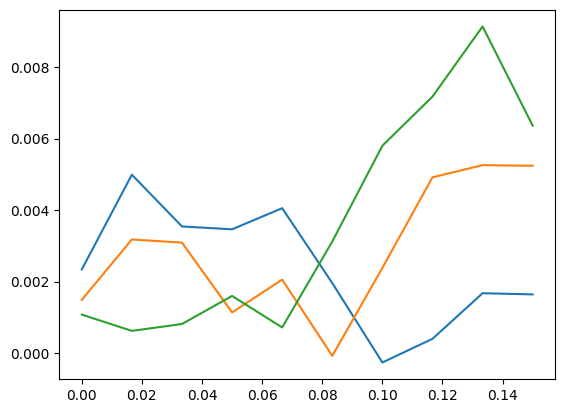

In [28]:
df = pd.DataFrame(classic_curve)
for mhl in df['max_history_leng'].unique()[:3]:
    ddf = df[df['max_history_leng'] == mhl]
    plt.plot(ddf['minimal_return'], ddf['mean_roi'])